# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
warnings.filterwarnings("ignore")

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data Wrangling

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


### the portfolio file has the reward that was set for a cusromer and when they have to reach that goal(in days)

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.shape

(17000, 5)

In [8]:
#Both the gender and income have the missing figures
#The became a member on column is an integer and it has to be a date date type 
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


### The profile file provides the demographics of the customer and what they earn.

In [9]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
transcript.shape

(306534, 4)

In [11]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## Data cleaning

#### profile

In [12]:
# convert dates to Datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


In [13]:
#Drop people who had a null gender
#profile = profile.dropna(subset=['gender'])
profile['income'] = profile['income'].fillna(profile['income'].mean())
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            17000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


In [14]:
# Extract the year from the became_member_on column
profile['year_joined'] = profile['became_member_on'].dt.year.astype(str)

# dummy variables for the gender column
gender_dummies = pd.get_dummies(profile['gender'], prefix='gender').astype(int)

# dummy variables for the year_joined
year_joined_dummies = pd.get_dummies(profile['year_joined'], prefix='year_joined').astype(int)

# Concatenate the dummy variables with the original DataFrame
profile = pd.concat([profile, gender_dummies, year_joined_dummies], axis=1)

# Drop the original columns that are no longer needed
profile.drop(columns=['became_member_on', 'year_joined'], inplace=True)

profile.rename(columns={'id':'consumer_id'}, inplace=True)

profile.head()

,gender,age,consumer_id,income,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0,0,0,0,0,0,0,1,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.000000,1,0,0,0,0,0,0,1,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,0,0,0,0,0,0,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,1,0,0,0,0,0,0,1,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,65404.991568,0,0,0,0,0,0,0,1,0


In [15]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   consumer_id       17000 non-null  object 
 3   income            17000 non-null  float64
 4   gender_F          17000 non-null  int64  
 5   gender_M          17000 non-null  int64  
 6   gender_O          17000 non-null  int64  
 7   year_joined_2013  17000 non-null  int64  
 8   year_joined_2014  17000 non-null  int64  
 9   year_joined_2015  17000 non-null  int64  
 10  year_joined_2016  17000 non-null  int64  
 11  year_joined_2017  17000 non-null  int64  
 12  year_joined_2018  17000 non-null  int64  
dtypes: float64(1), int64(10), object(2)
memory usage: 1.7+ MB


### portfolio

In [16]:
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# dummy variables for the channels
channels_encoded = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index).astype(int)

# dummy variables for the offer_type
offer_type_encoded = pd.get_dummies(portfolio['offer_type'], prefix='offer_type').astype(int)

# Concatenate the dummy variables with the original DataFrame
portfolio = pd.concat([portfolio, channels_encoded, offer_type_encoded], axis=1)

portfolio.rename(columns={'id':'reward_id'}, inplace=True)

# Display the first few rows of the DataFrame
portfolio.head()

,reward,channels,difficulty,duration,offer_type,reward_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


### Transcript

In [17]:
# Generate dummy variables for the event
event_dummies = pd.get_dummies(transcript['event']).astype(int)

# Remove the 'transaction' column from the dummy variables
event_dummies.drop(columns=['transaction'], inplace=True)

# Concatenate the dummy variables with the original DataFrame
transcript = pd.concat([transcript, event_dummies], axis=1)
transcript.rename(columns={'person':'consumer_id'}, inplace=True)

# Extract reward_id from the value column
transcript['reward_id'] = transcript['value'].apply(lambda x: list(x.values())[0] if list(x.keys())[0] in ['offer id', 'offer_id'] else None)

# Extract and round the transaction amount from the value column
transcript['amount'] = transcript['value'].apply(lambda x: np.round(list(x.values())[0], 2) if list(x.keys())[0] == 'amount' else None)

# Drop the value column
#transcript.drop(columns=['value'], inplace=True)

transcript.head()

,consumer_id,event,value,time,offer completed,offer received,offer viewed,reward_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   consumer_id      306534 non-null  object 
 1   event            306534 non-null  object 
 2   value            306534 non-null  object 
 3   time             306534 non-null  int64  
 4   offer completed  306534 non-null  int64  
 5   offer received   306534 non-null  int64  
 6   offer viewed     306534 non-null  int64  
 7   reward_id        167581 non-null  object 
 8   amount           138953 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 21.0+ MB


## Merge all dataframes

In [19]:
trans_merge = pd.merge(transcript, profile, on='consumer_id',how="left")
df = pd.merge(trans_merge,portfolio, on='reward_id', how='left')
df.head()

,consumer_id,event,value,time,offer completed,offer received,offer viewed,reward_id,amount,gender,...,difficulty,duration,offer_type,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,...,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,...,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,...,10.0,10.0,discount,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,...,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0


## Exploratory analysis

#The total number of events recorded is 306,534
#df.shape

## Gender VS offers 

#### More men seem to be buying at Starbucks

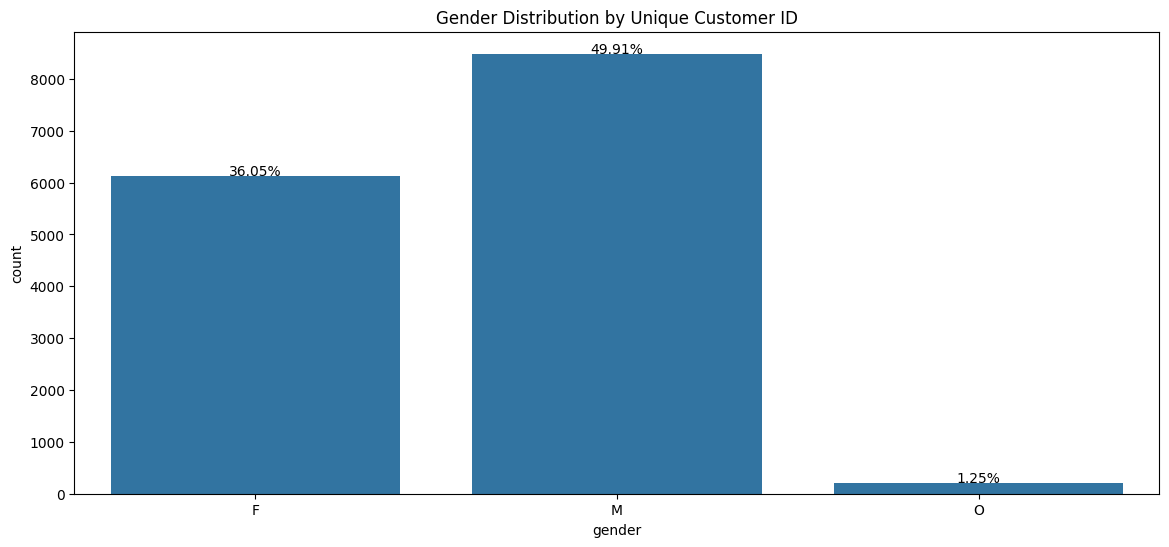

In [20]:
# Drop duplicate customer_id to ensure each customer is counted only once
unique_customers = df.drop_duplicates(subset='consumer_id')

# Plot the gender distribution
f, ax = plt.subplots(figsize=(14, 6))
ax = sns.countplot(x="gender", data=unique_customers)

# Add percentage labels on top of each bar
total = float(len(unique_customers))  # Total number of unique customers
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, '{:.2f}%'.format((height / total) * 100), ha="center")

# Set x-axis labels to be vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=360)

plt.title('Gender Distribution by Unique Customer ID')
plt.show()

In [21]:
# Count the number of offers received by gender and offer type
offers_received = df[df['event'] == 'offer received'].groupby(['gender', 'offer_type'])['consumer_id'].count().reset_index()
offers_received.columns = ['Gender', 'Offer Type', 'Received']

# Count the number of offers completed by gender and offer type
offers_completed = df[df['event'] == 'offer completed'].groupby(['gender', 'offer_type'])['consumer_id'].count().reset_index()
offers_completed.columns = ['Gender', 'Offer Type', 'Completed']

# Merge received and completed offers
offer_conversion = offers_received.merge(offers_completed, on=['Gender', 'Offer Type'], how='left').fillna(0)

# Calculate conversion rate
offer_conversion['Conversion Rate (%)'] = (offer_conversion['Completed'] / offer_conversion['Received']) * 100

# Display results
print(offer_conversion)


  Gender     Offer Type  Received  Completed  Conversion Rate (%)
0      F           bogo     10975     7501.0            68.346241
1      F       discount     10943     7976.0            72.886777
2      F  informational      5538        0.0             0.000000
3      M           bogo     15208     7512.0            49.395055
4      M       discount     15354     8954.0            58.317051
5      M  informational      7567        0.0             0.000000
6      O           bogo       354      245.0            69.209040
7      O       discount       367      256.0            69.754768
8      O  informational       195        0.0             0.000000


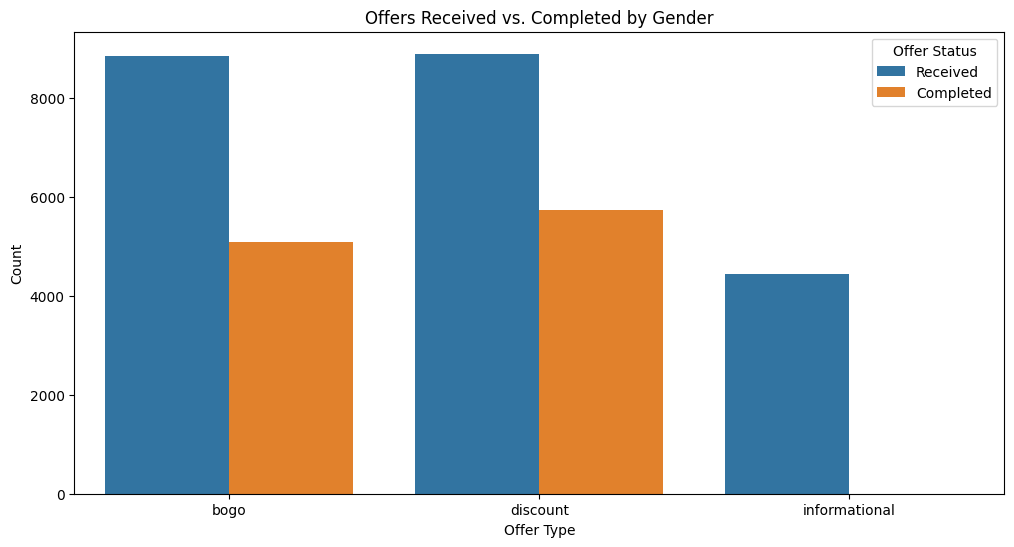

In [22]:
# Convert to long format for visualization
offer_conversion_melted = offer_conversion.melt(id_vars=['Gender', 'Offer Type'], 
                                                value_vars=['Received', 'Completed'], 
                                                var_name='Status', value_name='Count')

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=offer_conversion_melted, x='Offer Type', y='Count', hue='Status', ci=None)
plt.title("Offers Received vs. Completed by Gender")
plt.xlabel("Offer Type")
plt.ylabel("Count")
plt.legend(title="Offer Status")
plt.show()


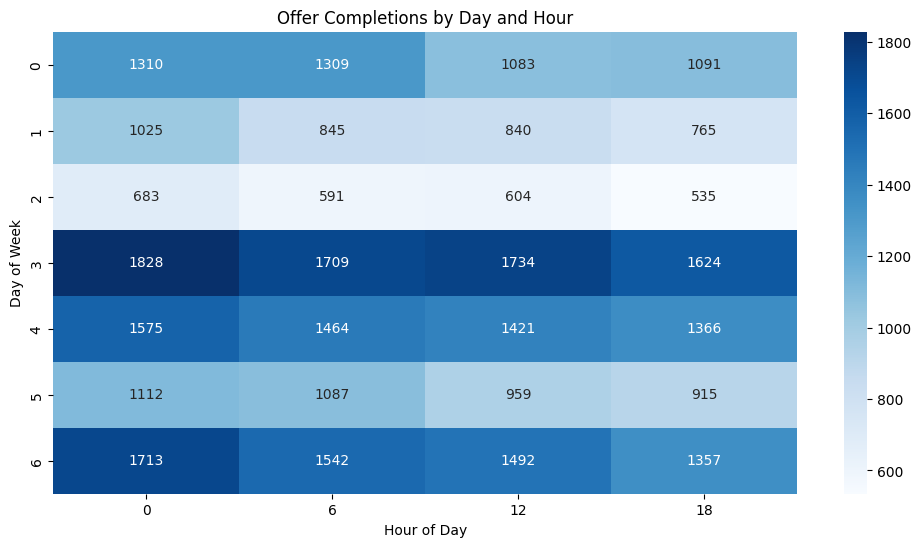

In [23]:
#best day of the week to send id thursday, friday and sunday
# Convert time column to datetime (if not already)
df['time'] = pd.to_datetime(df['time'], unit='h')

# Extract day of the week and hour
df['day_of_week'] = df['time'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['hour'] = df['time'].dt.hour

# Analyze completed offers by time
offer_time_analysis = df[df['event'] == 'offer completed'].groupby(['day_of_week', 'hour'])['consumer_id'].count().reset_index()
offer_time_analysis.columns = ['Day of Week', 'Hour', 'Completed Offers']

# Pivot the table correctly
offer_pivot = offer_time_analysis.pivot(index='Day of Week', columns='Hour', values='Completed Offers').fillna(0)

# Visualize offer completions by time
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(offer_pivot, cmap="Blues", annot=True, fmt=".0f")
plt.title("Offer Completions by Day and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


In [24]:
# Define engagement levels based on offer completions
engagement = df[df['event'] == 'offer completed'].groupby('consumer_id')['event'].count()
df['engagement_level'] = df['consumer_id'].map(lambda x: 'Low' if x in engagement[engagement <= 2].index
                                               else 'Medium' if x in engagement[(engagement > 2) & (engagement <= 5)].index
                                               else 'High')

# Define spending power based on income
df['spending_power'] = pd.qcut(df['income'], q=3, labels=['Low', 'Medium', 'High'])

# Find preferred offer type per customer
preferred_offer = df[df['event'] == 'offer completed'].groupby('consumer_id')['offer_type'].agg(lambda x: x.mode()[0])
df['preferred_offer'] = df['consumer_id'].map(preferred_offer)

# Display segmented data
df[['consumer_id', 'engagement_level', 'spending_power', 'preferred_offer']].drop_duplicates()


,consumer_id,engagement_level,spending_power,preferred_offer
0,78afa995795e4d85b5d9ceeca43f5fef,Medium,High,bogo
1,a03223e636434f42ac4c3df47e8bac43,High,Medium,NaN
2,e2127556f4f64592b11af22de27a7932,Low,Medium,bogo
3,8ec6ce2a7e7949b1bf142def7d0e0586,High,Medium,NaN
4,68617ca6246f4fbc85e91a2a49552598,High,Medium,NaN
...,...,...,...,...
213585,9fcbff4f8d7241faa4ab8a9d19c8a812,High,High,NaN
222411,ebae5093b436466c9fbd097cb7434023,Low,Medium,discount
249251,912b9f623b9e4b4eb99b6dc919f09a93,High,Medium,NaN
253904,3045af4e98794a04a5542d3eac939b1f,High,High,NaN


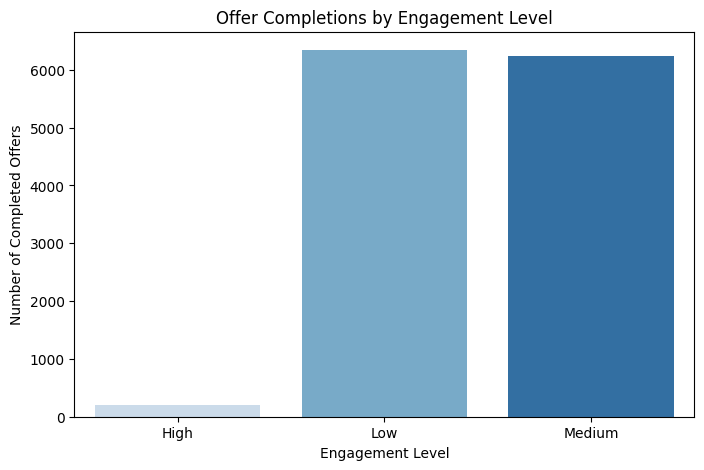

In [25]:
# Count offer completions per engagement level
engagement_conversion = df[df['event'] == 'offer completed'].groupby('engagement_level')['consumer_id'].nunique().reset_index()
engagement_conversion.columns = ['Engagement Level', 'Completed Offers']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=engagement_conversion, x='Engagement Level', y='Completed Offers', palette='Blues')
plt.title("Offer Completions by Engagement Level")
plt.ylabel("Number of Completed Offers")
plt.xlabel("Engagement Level")
plt.show()

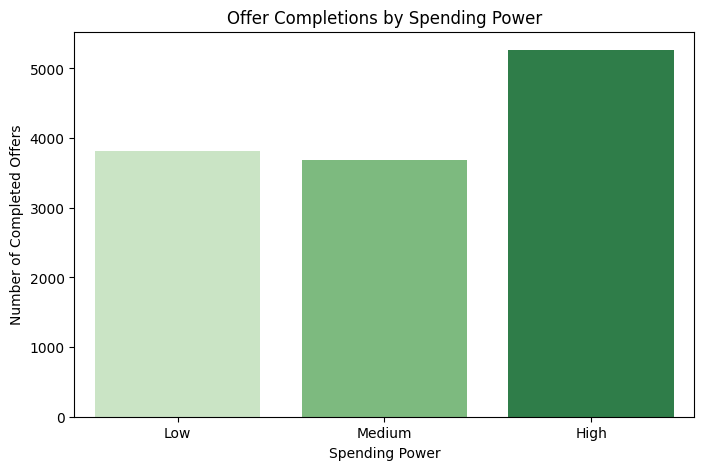

In [26]:
spending_conversion = df[df['event'] == 'offer completed'].groupby('spending_power')['consumer_id'].nunique().reset_index()
spending_conversion.columns = ['Spending Power', 'Completed Offers']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=spending_conversion, x='Spending Power', y='Completed Offers', palette='Greens')
plt.title("Offer Completions by Spending Power")
plt.ylabel("Number of Completed Offers")
plt.xlabel("Spending Power")
plt.show()

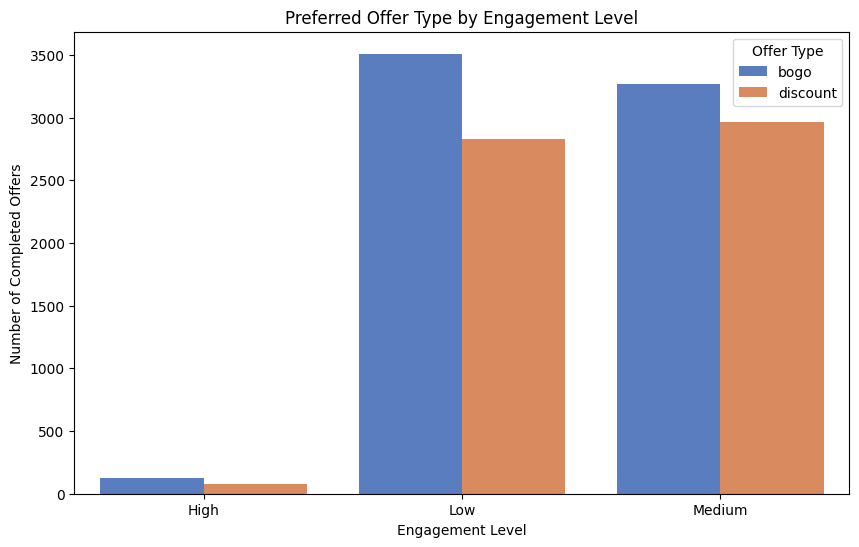

In [27]:
# Count offer types completed per engagement level
offer_engagement = df[df['event'] == 'offer completed'].groupby(['engagement_level', 'preferred_offer'])['consumer_id'].nunique().reset_index()
offer_engagement.columns = ['Engagement Level', 'Offer Type', 'Completed Offers']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=offer_engagement, x='Engagement Level', y='Completed Offers', hue='Offer Type', palette='muted')
plt.title("Preferred Offer Type by Engagement Level")
plt.ylabel("Number of Completed Offers")
plt.xlabel("Engagement Level")
plt.legend(title="Offer Type")
plt.show()


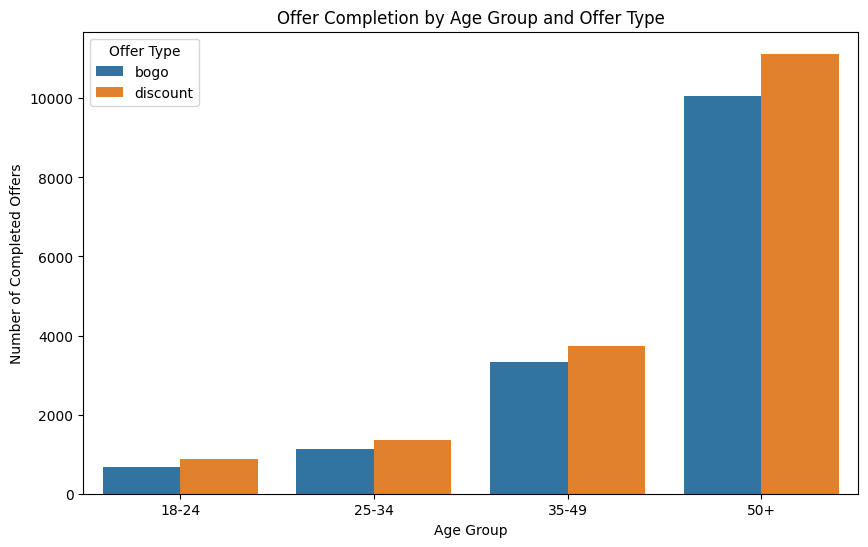

In [28]:
# Define age groups
bins = [18, 25, 35, 50, 100]
labels = ['18-24', '25-34', '35-49', '50+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# Count completed offers per age group and offer type
age_offer_analysis = df[df['event'] == 'offer completed'].groupby(['age_group', 'offer_type'])['consumer_id'].count().reset_index()

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=age_offer_analysis, x='age_group', y='consumer_id', hue='offer_type')
plt.title("Offer Completion by Age Group and Offer Type")
plt.xlabel("Age Group")
plt.ylabel("Number of Completed Offers")
plt.legend(title="Offer Type")
plt.show()


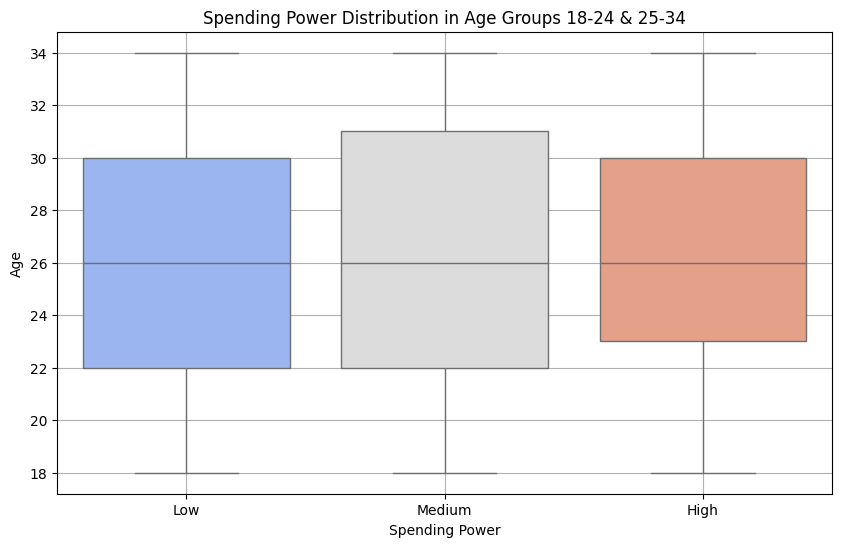

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define age groups
age_groups = {
    '18-24': (18, 24),
    '25-34': (25, 34)
}

# Filter dataset for relevant age groups
df_filtered = df[(df['age'] >= 18) & (df['age'] <= 34)]

# Define spending power based on income (Low, Medium, High)
df_filtered['spending_power'] = pd.qcut(df_filtered['income'], q=3, labels=['Low', 'Medium', 'High'])

# Count spending power distribution per age group
spending_distribution = df_filtered.groupby(['age', 'spending_power'])['consumer_id'].nunique().reset_index()
spending_distribution.columns = ['Age', 'Spending Power', 'Count']

# Plot distribution of spending power by age
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='spending_power', y='age', order=['Low', 'Medium', 'High'], palette='coolwarm')
plt.title("Spending Power Distribution in Age Groups 18-24 & 25-34")
plt.xlabel("Spending Power")
plt.ylabel("Age")
plt.grid()
plt.show()


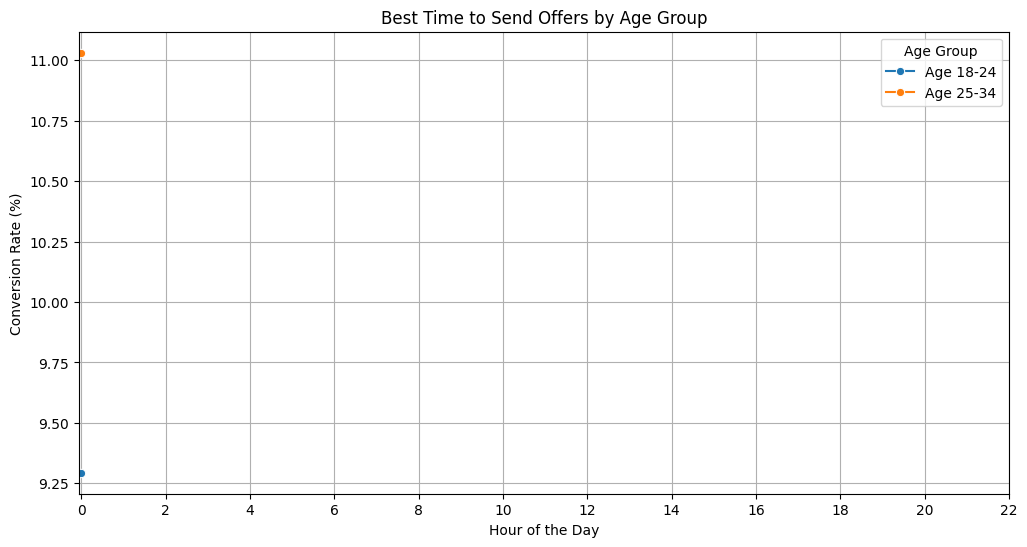

🔥 Best time to send offers for age 18-24: 6:00
🔥 Best time to send offers for age 25-34: 6:00


In [30]:
# Convert time column to datetime (if not already)
df['time'] = pd.to_datetime(df['time'], unit='h')

# Extract hour of day
df['hour'] = df['time'].dt.hour

# Define age groups
age_groups = {
    '18-24': (18, 24),
    '25-34': (25, 34)
}

# Initialize plot
plt.figure(figsize=(12, 6))

best_hours = {}  # Store best hours for each age group

# Loop through each age group and analyze best offer time
for group, (age_min, age_max) in age_groups.items():
    df_filtered = df[(df['age'] >= age_min) & (df['age'] <= age_max)]

    # Count received and completed offers per hour
    offers_received = df_filtered[df_filtered['event'] == 'offer received'].groupby('hour')['consumer_id'].count().reset_index()
    offers_received.columns = ['Hour', 'Offers Received']

    offers_completed = df_filtered[df_filtered['event'] == 'offer completed'].groupby('hour')['consumer_id'].count().reset_index()
    offers_completed.columns = ['Hour', 'Offers Completed']

    # Merge datasets
    offer_timing = pd.merge(offers_received, offers_completed, on='Hour', how='outer').fillna(0)

    # Calculate conversion rate per hour
    offer_timing['Conversion Rate (%)'] = (offer_timing['Offers Completed'] / offer_timing['Offers Received']) * 100

    # Find the best hour for this age group
    best_hour = offer_timing.loc[offer_timing['Conversion Rate (%)'].idxmax(), 'Hour']
    best_hours[group] = int(best_hour)

    # Plot conversion rates
    sns.lineplot(data=offer_timing, x='Hour', y='Conversion Rate (%)', marker='o', label=f'Age {group}')

# Customize plot
plt.title("Best Time to Send Offers by Age Group")
plt.xlabel("Hour of the Day")
plt.ylabel("Conversion Rate (%)")
plt.xticks(range(0, 24, 2))  # Show every 2-hour interval
plt.legend(title="Age Group")
plt.grid()
plt.show()

# Print best times
for group, hour in best_hours.items():
    print(f"🔥 Best time to send offers for age {group}: {hour}:00")


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare data
df_ml = df[['gender', 'age', 'income', 'offer_type', 'event']]
df_ml = pd.get_dummies(df_ml, columns=['gender', 'offer_type'], drop_first=True)  # Encode categorical vars
df_ml['event'] = df_ml['event'].apply(lambda x: 1 if x == 'offer completed' else 0)  # Convert target to binary

# Split data
X = df_ml.drop(columns=['event'])
y = df_ml['event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predictions & performance
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.99      0.94     54542
           1       0.03      0.00      0.01      6765

    accuracy                           0.88     61307
   macro avg       0.46      0.50      0.47     61307
weighted avg       0.79      0.88      0.83     61307



## Offer Recommendation

### Best day of the week to send is thursday, friday and sunday

### Segmentation 1 
### Customers in this age range 18-34 receive regular BOGO offers with low engagement, and practically no discount offers. These BOGO offers involve more valuable rewards this will increase their conversion rate and there give higher spend.
### Normally when this age group sees somthing free they normally buy

### Segmentation 2
### Male Customers normally do not convert to the offers send to them so making a segment for them which is a happy hour lower discount 50% to the best drink on fridays at 6 A.M this will increase their spend and they will now come to buy next time when they have tested the best.

### Segmentation 3
### Females are very particular having personalised message because they buy off emotions, so grate a social experience outside of just drink, for example give them a free yoga class once a month.